In [309]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [310]:
import os
for dirname, _, filenames in os.walk('../vladv/data_files/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../vladv/data_files/test.csv
../vladv/data_files/train.csv


In [311]:
import warnings
warnings.filterwarnings('ignore')

In [312]:
matplotlib.rcParams.update({'font.size': 16})

In [313]:
train_df = pd.read_csv('Desktop/GeekBrains/train.csv')
test_df = pd.read_csv('Desktop/GeekBrains/test.csv')

Функция оценки качества по коэффициенту детерминации.

In [314]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    '''
    
    '''
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Обзор данных

In [315]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [316]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [317]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))


# Приведение типов данных

In [318]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Приведем Id к текстовому типу данных, чтобы он не попал в выборку.

In [319]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Id'].dtype

dtype('O')

In [320]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['Id'].dtype

dtype('O')

Обзор количественных переменных

In [321]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])

In [322]:
df_num_features.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


Обзор номинативных переменных

In [323]:
df_object_features = train_df.select_dtypes(include=['object'])
df_object_features.head()

,Id,Ecology_2,Ecology_3,Shops_2
0,14038,B,B,B
1,15053,B,B,B
2,4765,B,B,B
3,5809,B,B,B
4,10783,B,B,B


In [324]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [325]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [326]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Заменим признаки на 0 и 1 соответственно.

In [327]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A' : 0, 'B' : 1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A' : 0, 'B' : 1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A' : 0, 'B' : 1})

In [328]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A' : 0, 'B' : 1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A' : 0, 'B' : 1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A' : 0, 'B' : 1})

In [329]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,...,7960,6,350.0,3,11,B,196684.316040,1,1,1
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,5562,0,NaN,0,5,A,189050.289571,1,1,0
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,...,629,1,NaN,0,0,A,159143.805370,1,1,0
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,5048,9,325.0,2,5,B,181595.339808,1,0,1
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,...,4798,0,30.0,2,8,B,218714.077615,1,1,1


In [330]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Ecology_2_bin       0
Ecology_3_bin       0
Shops_2_bin         0
dtype: int64

In [331]:
train_df.loc[train_df['Healthcare_1'].isnull(), :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,B,184966.930730,1,1,1
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,4386,14,NaN,1,5,B,296021.204377,1,1,1
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,1437,3,NaN,0,2,B,221244.156664,1,1,1
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,...,264,0,NaN,0,1,B,229102.795999,1,1,1
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,1437,3,NaN,0,2,B,95380.220993,1,1,1


In [332]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [333]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [334]:
train_df.loc[train_df['LifeSquare'].isnull(), :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,1437,3,900.0,0,2,B,221244.156664,1,1,1
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,...,264,0,900.0,0,1,B,229102.795999,1,1,1
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,...,1892,0,900.0,0,1,B,127200.026511,1,1,1
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,...,5285,0,645.0,6,6,B,571069.052600,1,1,1
25,5073,74,2.0,82.667915,NaN,1.0,16,17.0,1977,0.075779,...,1437,3,900.0,0,2,B,244145.827069,1,1,1


In [335]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['Square'].median()
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['Square'].median()

In [336]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,900.0,0,11,B,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,1,1,1




# Обработка выбросов

In [337]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,40.435422,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,43.587592,0.839512,21.058732,76.843482,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,36.000000,2.000000,52.513310,38.334514,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,75.000000,2.000000,65.900625,52.513310,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


Rooms

In [338]:
train_df[(train_df['Rooms']<1) | (train_df['Rooms']>5)].head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,19083,2,900.0,5,15,B,317265.323792,1,1,1
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,3097,0,900.0,0,0,B,268394.744389,1,1,1
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,264,0,900.0,0,1,B,78364.616704,1,1,1
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,900.0,0,1,B,302211.260887,1,1,1
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,10573,1,1322.0,3,8,B,229661.964416,1,1,1


In [339]:
train_df['Rooms'].mode()[0]

2.0

In [340]:
train_df.loc[(train_df['Rooms'] < 1) | (train_df['Rooms'] > 5), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] < 1) | (test_df['Rooms'] > 5), 'Rooms'] = train_df['Rooms'].mode()[0]


Square

In [341]:
train_df.nlargest(5, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,6398,141,1046.0,3,23,B,133529.681562,1,1,1
4262,28,9,2.0,604.705972,52.513310,1.0,17,18.0,1977,0.161532,...,5648,1,30.0,2,4,B,187717.242538,1,1,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,3889,6,705.0,3,6,B,90470.430830,1,1,1
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,7010,5,4508.0,3,7,B,455264.882666,1,0,1
1981,7917,27,2.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,900.0,0,1,B,302211.260887,1,1,1


In [342]:
train_df.loc[(train_df['Square'] < 15) | (train_df['Square'] > 300), 'Square'] = train_df['Square'].median()

Life Square

In [343]:
train_df.nlargest(5, 'LifeSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,...,469,0,900.0,0,0,B,217357.492366,1,1,1
6977,11602,30,2.0,52.513310,638.163193,10.0,20,19.0,2019,0.000078,...,6398,141,1046.0,3,23,B,133529.681562,1,1,1
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,...,11217,1,2300.0,1,7,B,394253.299978,1,1,1
4690,2307,102,1.0,52.513310,410.639749,10.0,4,4.0,2016,0.238617,...,3889,6,705.0,3,6,B,90470.430830,1,1,1
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,...,1437,3,900.0,0,2,B,141780.231857,1,1,1


In [344]:
train_df.loc[(train_df['LifeSquare']<15) | (train_df['LifeSquare']>250), 'LifeSquare'] = train_df['Square']

In [345]:
test_df.loc[(test_df['LifeSquare'] < 15) | (test_df['LifeSquare'] > 250), 'LifeSquare'] = train_df['Square']

In [346]:
train_df[(train_df['LifeSquare']>15) | (train_df['LifeSquare']<250)].head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,900.0,0,11,B,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,1,1,1


Kitchen Square

In [347]:
train_df.nlargest(10, 'KitchenSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,...,629,1,900.0,0,0,A,108337.484207,1,1,0
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,...,5285,0,645.0,6,6,B,105539.556275,1,1,1
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,...,469,0,900.0,0,0,B,234194.837047,1,1,1
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,...,629,1,900.0,0,0,A,315245.521059,1,1,0
4651,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016,0.437885,...,5735,3,1084.0,0,5,B,296165.936689,1,1,1
2916,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,...,2398,2,1994.0,3,0,B,445074.956552,1,1,1
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,...,915,0,900.0,0,0,B,99079.960518,1,1,1
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,...,5285,0,645.0,6,6,B,438708.707579,1,1,1
6240,4966,96,3.0,78.445675,47.146757,75.0,9,12.0,1977,0.041116,...,14892,4,900.0,1,4,B,290354.484070,1,1,1
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,...,5731,0,900.0,1,0,B,160488.033165,1,1,1


In [348]:
train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [349]:
test_df.loc[test_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

Также заменим нелогичные данные мединой, где площадь кухни больше чем жилая площадь.

In [350]:
train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare'], 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [351]:
test_df.loc[test_df['KitchenSquare'] > test_df['LifeSquare'], 'KitchenSquare'] = train_df['KitchenSquare'].median()

HouseFloor

In [352]:
train_df.nlargest(5, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
8854,78,30,2.0,65.773749,66.811789,4.0,8,117.0,1977,0.000078,...,6398,141,1046.0,3,23,B,207248.370520,1,1,1
6131,10806,5,1.0,51.944587,48.709601,4.0,6,99.0,1977,0.150818,...,3433,4,2643.0,4,5,B,296127.115515,1,1,1
8599,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,...,1437,3,900.0,0,2,B,243329.912579,1,1,1
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,...,1660,39,1786.0,1,5,B,411691.504766,1,1,1
7728,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,...,12238,8,1970.0,2,3,B,179396.521035,1,1,1


In [353]:
train_df.loc[(train_df['HouseFloor'] < 2) | (train_df['HouseFloor'] > 50), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [354]:
test_df.loc[(test_df['HouseFloor'] < 2) | (test_df['HouseFloor'] > 50), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

Floor

In [355]:
train_df[train_df['Floor']>train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
14,10953,27,1.0,53.769097,52.408027,4.0,5,4.0,1977,0.072158,...,629,1,900.0,0,0,A,140647.565937,1,1,0
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,...,1227,0,900.0,0,0,B,117000.381287,1,1,1
35,6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000,...,7425,1,900.0,2,5,B,402871.916317,1,1,1
44,10521,38,3.0,104.211396,106.340403,4.0,20,17.0,2017,0.060753,...,2787,2,520.0,0,7,B,435462.048070,1,1,1
51,10103,94,1.0,35.280894,23.354176,6.0,11,9.0,1971,0.282798,...,8667,2,900.0,0,6,B,148862.210174,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,5071,27,2.0,60.055527,52.513310,12.0,16,15.0,1977,0.072158,...,629,1,900.0,0,0,A,190325.071232,1,1,0
9984,2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,...,7065,1,750.0,2,5,B,226434.880156,1,1,1
9989,4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,...,14892,4,900.0,1,4,B,441108.911237,1,1,1
9991,11553,3,3.0,101.622794,51.628780,12.0,18,17.0,2000,0.265089,...,5288,0,1937.0,3,2,B,212883.501504,1,1,1


In [356]:
train_df.loc[train_df['Floor']>train_df['HouseFloor'], 'Floor'] = train_df['Floor']
test_df.loc[test_df['Floor']>test_df['HouseFloor'], 'Floor'] = train_df['Floor']

House Year

In [357]:
train_df.nlargest(10, 'HouseYear')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,6141,10,262.0,3,6,B,254084.534396,1,1,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,4756,16,2857.0,5,8,B,243028.603096,1,1,1
585,15051,53,2.0,59.597891,44.869530,10.0,3,24.0,2020,0.049637,...,7759,0,229.0,1,3,B,243114.222804,1,1,1
707,4345,62,1.0,49.275155,49.275155,4.0,5,17.0,2020,0.072158,...,629,1,900.0,0,0,A,135353.885620,1,1,0
790,6845,169,3.0,87.371123,64.905206,12.0,4,24.0,2020,0.178917,...,3594,4,192.0,1,5,B,295304.011974,1,1,1
918,2530,53,2.0,64.233072,47.405440,13.0,13,24.0,2020,0.049637,...,7759,0,229.0,1,3,B,283334.496716,1,1,1
1499,6731,120,2.0,85.087643,77.976325,10.0,7,10.0,2020,0.341072,...,5664,48,2300.0,3,11,B,536020.260344,1,1,1
2493,3445,53,1.0,35.672788,21.391266,8.0,4,24.0,2020,0.049637,...,7759,0,229.0,1,3,B,170847.416766,1,1,1
2877,8832,1,3.0,83.260743,79.438325,4.0,15,21.0,2020,0.007122,...,264,0,900.0,0,1,B,242243.090839,1,1,1
3357,9600,62,1.0,55.911215,43.821379,10.0,6,17.0,2020,0.072158,...,629,1,900.0,0,0,A,138770.715048,1,1,0


In [358]:
train_df.loc[train_df['HouseYear']>2021, 'HouseYear'] = train_df['HouseYear'].median()
test_df.loc[test_df['HouseYear']>2021, 'HouseYear'] = train_df['HouseYear'].median()

In [359]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888400,56.228457,40.771414,6.828700,8.526700,13.835500,1984.863800,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,43.587592,0.811056,19.058793,16.760534,3.867719,5.241148,5.686271,18.409979,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.000000,1.000000,16.117154,15.001234,4.000000,1.000000,2.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.800063,27.817111,4.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,36.000000,2.000000,52.513310,39.968981,6.000000,7.000000,16.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,75.000000,2.000000,65.889736,52.513310,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,209.000000,5.000000,275.645284,233.949309,123.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


# Отбор признаков

In [360]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,900.0,0,11,B,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,1,1,1


исключим Id, Ecology_2, Ecology_3, Shops_2 как неподходящие для основной выборки

In [361]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
target_name = 'Price'

array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>],
       [<AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>]],
      dtype=object)

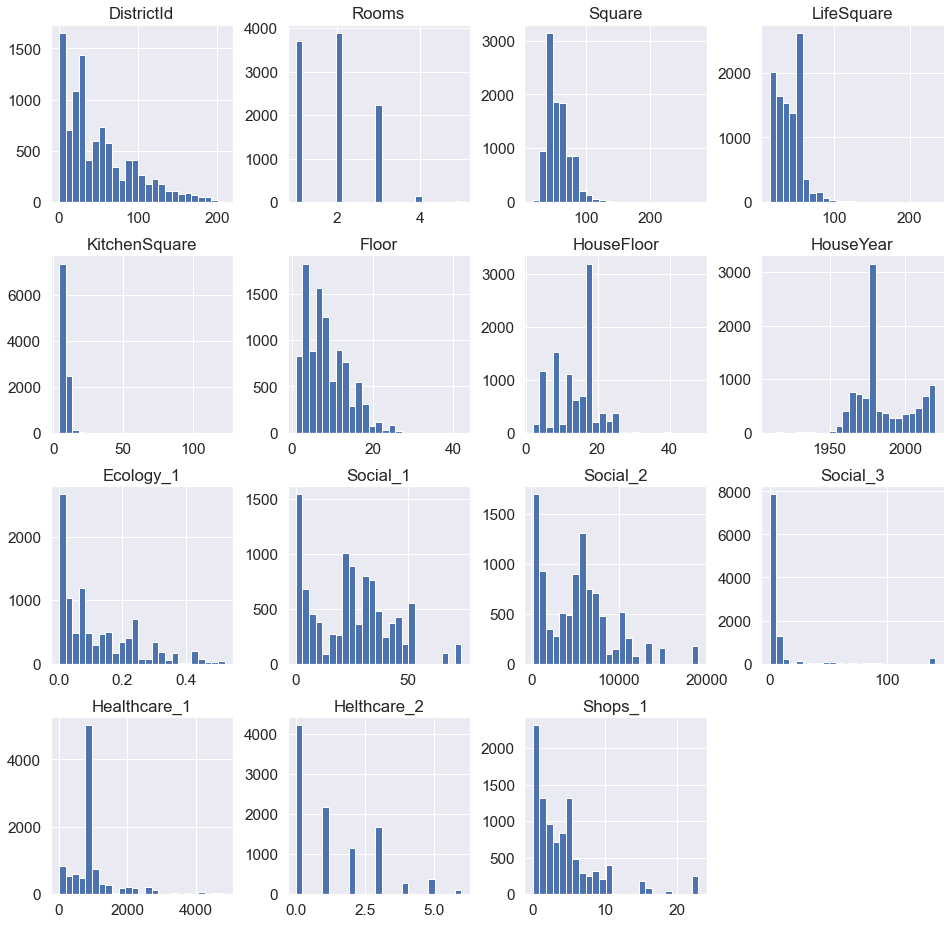

In [362]:
train_df[['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1','Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1']].hist(figsize=(16,16), bins=25, grid=True)

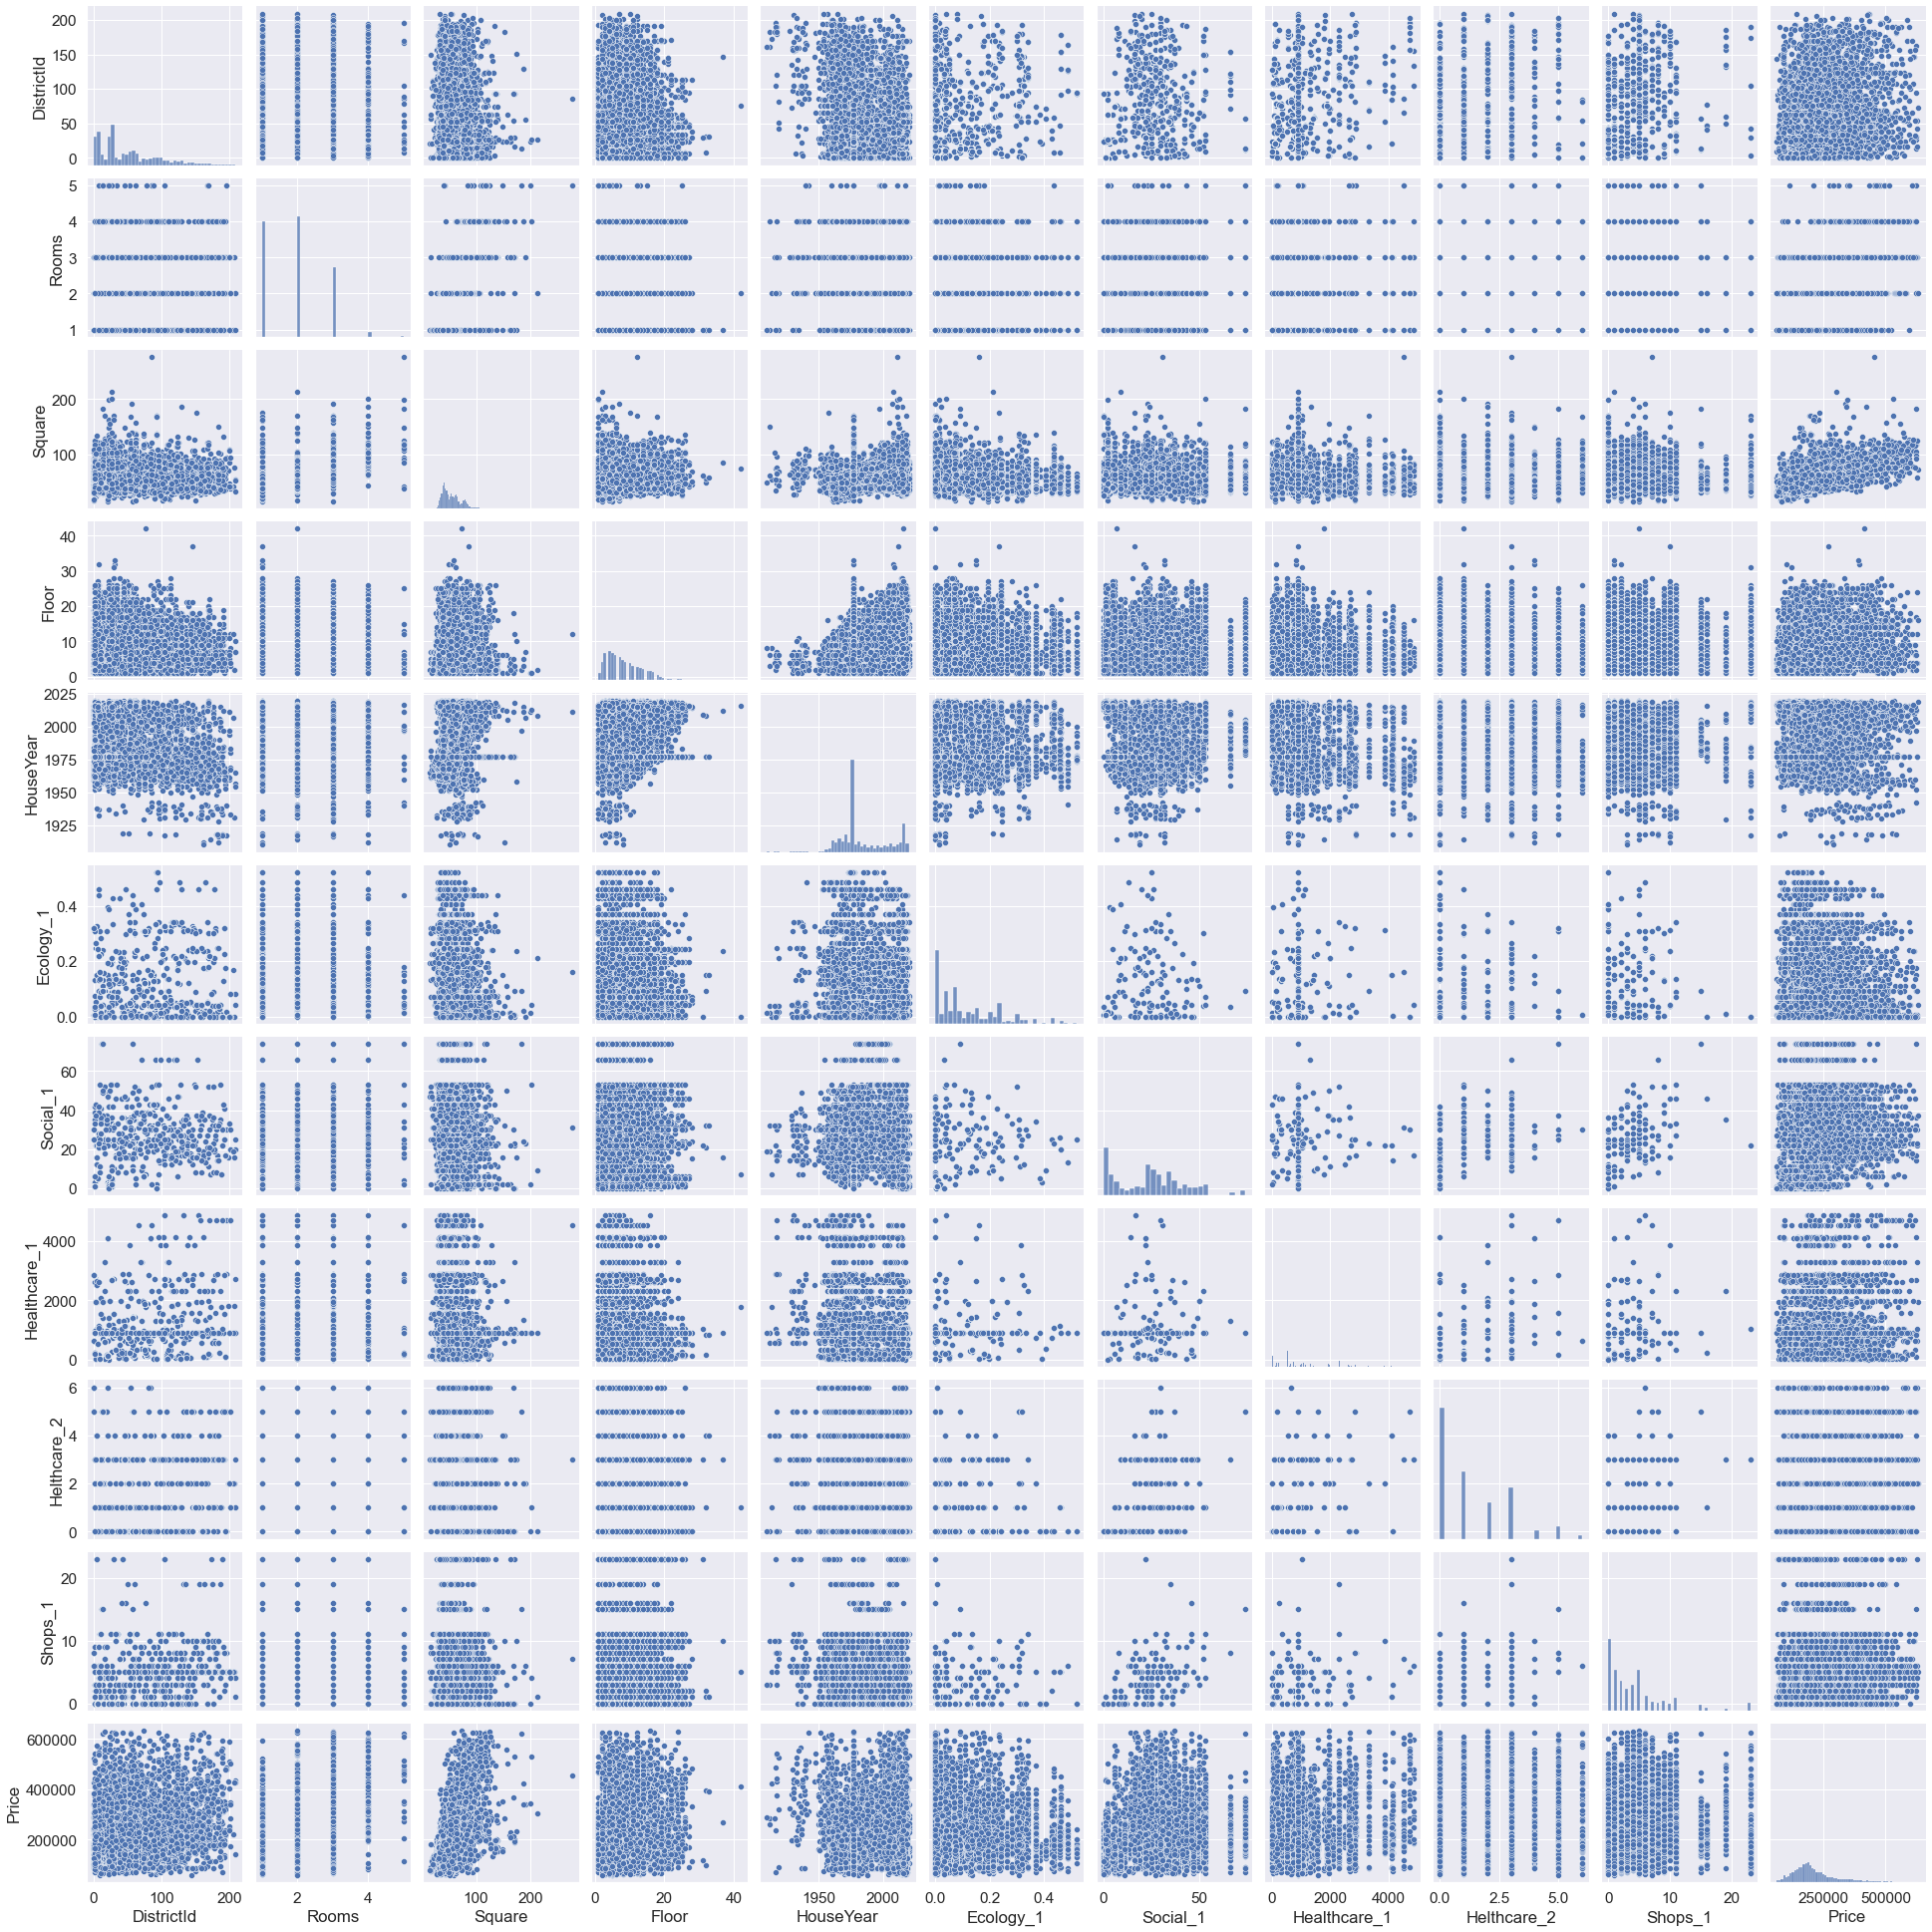

In [363]:
sns.pairplot(train_df[['DistrictId', 'Rooms', 'Square', 'Floor', 'HouseYear', 'Ecology_1', 'Social_1', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price']])

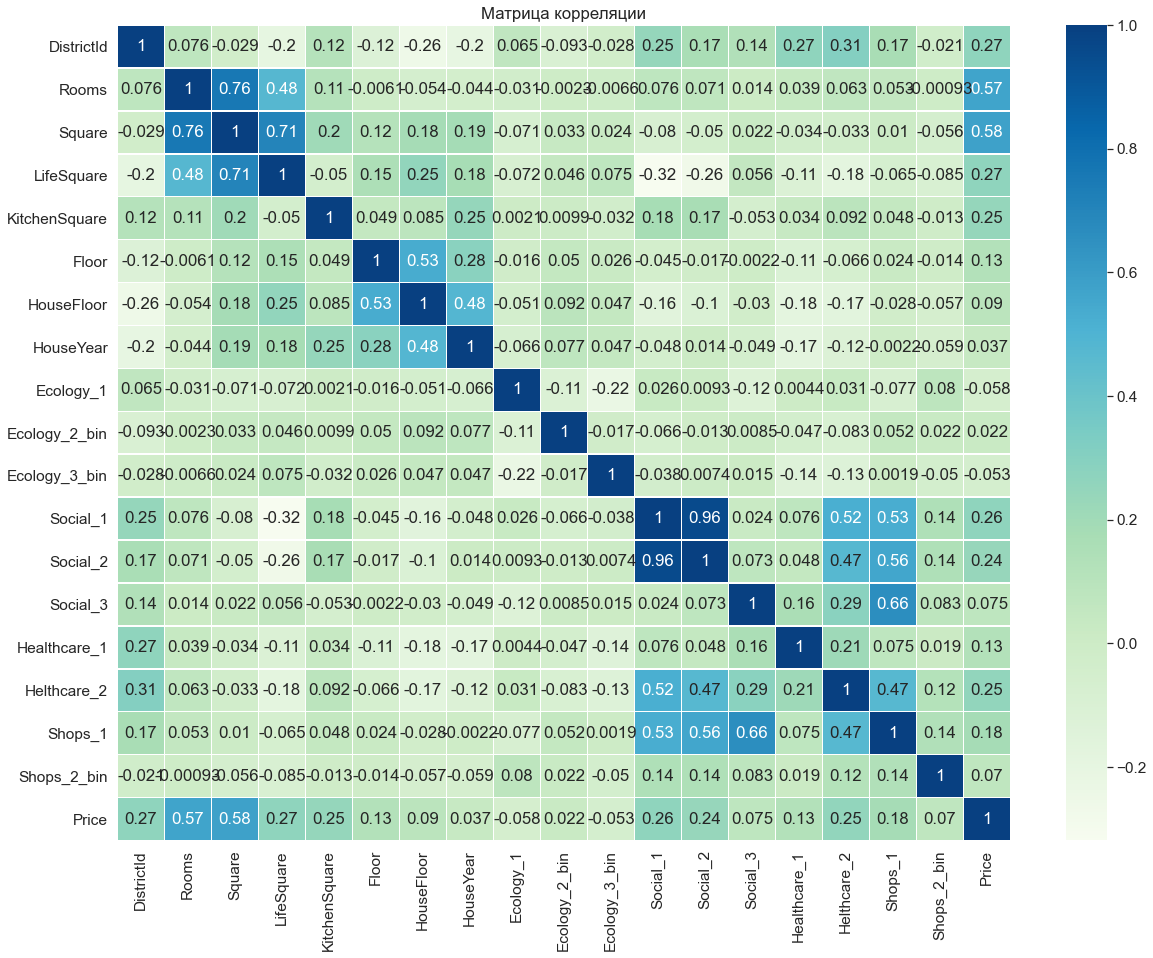

In [364]:
plt.figure(figsize=(20,15))

sns.set(font_scale=1.4)
sns.heatmap(train_df[feature_names + ['Price']].corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляции')
plt.show()

уберем признак Social_2, т.к. он сильно кореллирует с Social_1

In [365]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
target_name = 'Price'

In [366]:
train_df = train_df[feature_names + [target_name]]
test_df = test_df[feature_names]
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,5,900.0,0,11,1,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,1,240.0,1,16,1,300009.450063
2,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,1,1,34,0,229.0,1,3,1,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,3,1084.0,0,5,1,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,1,2078.0,2,4,1,150226.531644


# Анализ целевой переменной

In [367]:
target_mean = round(train_df[target_name].mean(), 2)
target_mean

214138.86

In [368]:
target_median = round(train_df[target_name].median(), 2)
target_median 

192269.64

In [369]:
target_mode = round(train_df[target_name].mode()[0], 2)
target_mode

59174.78

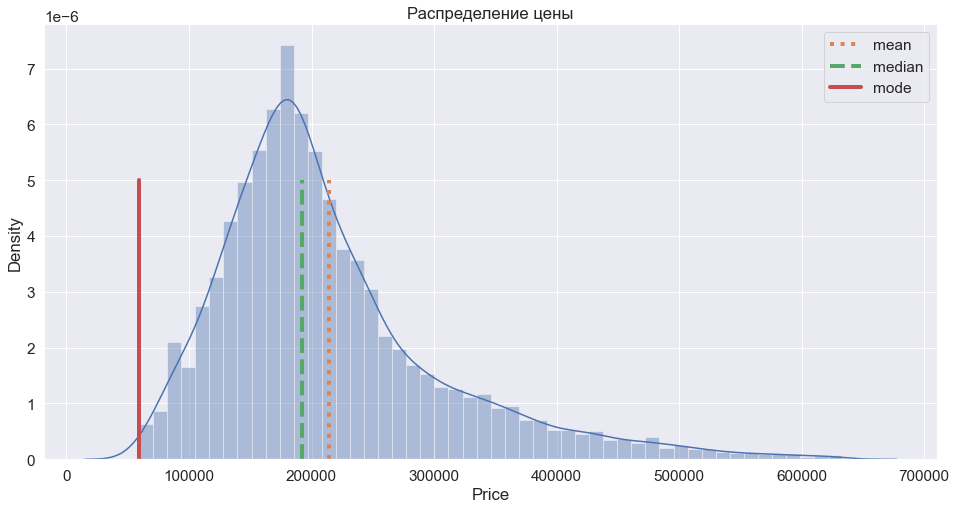

In [370]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df[target_name])

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean]*10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median]*10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode]*10, y, label='mode', linestyle='-', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()

# Оценка распределения цены в разрезе других признаков

Общая площадь жилья

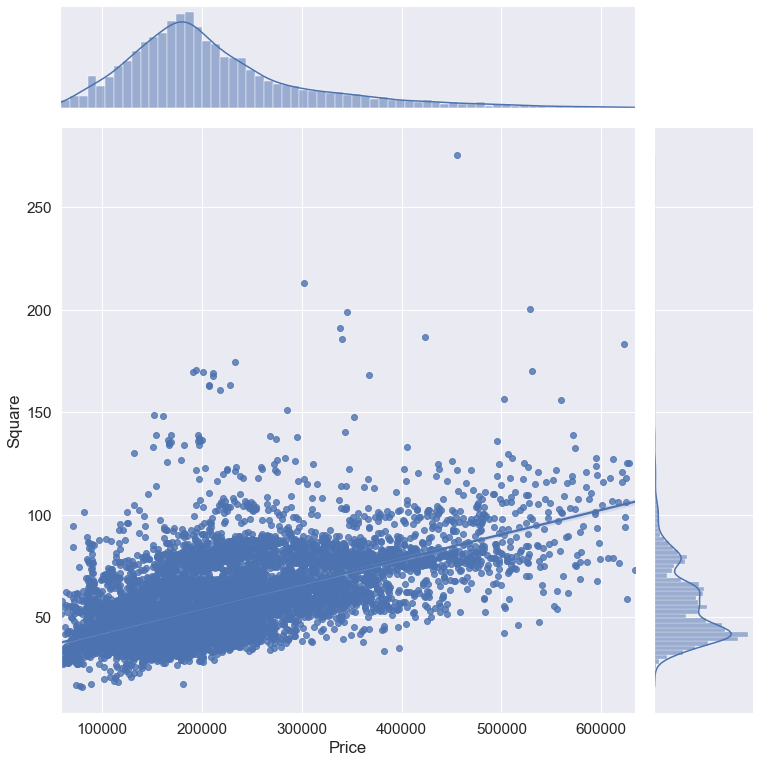

In [371]:
grid = sns.jointplot(train_df[target_name], train_df['Square'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

Район

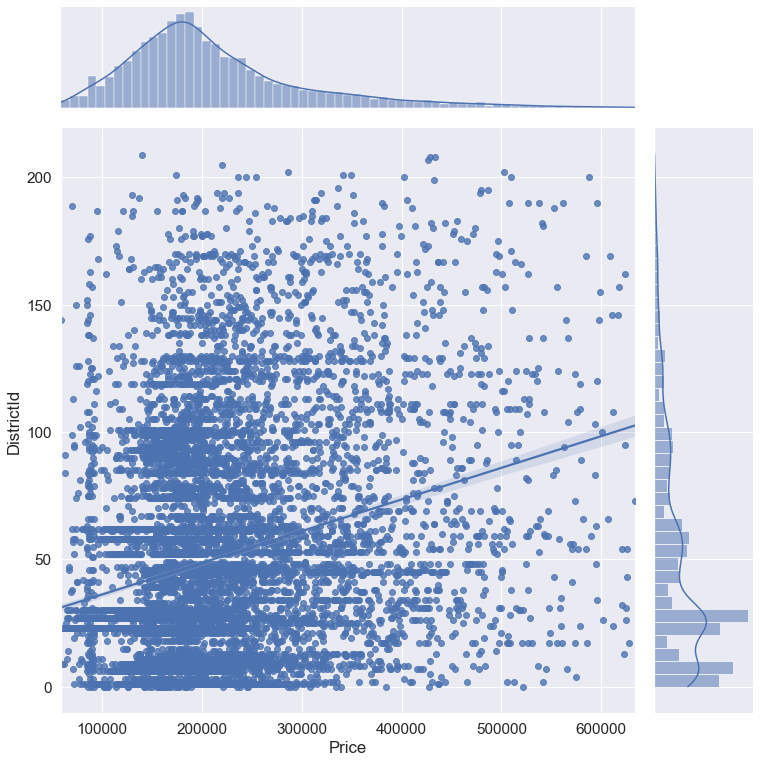

In [372]:
grid = sns.jointplot(train_df[target_name], train_df['DistrictId'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

# Стандартизация признаков

In [373]:
feature_names_for_stand = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1']

In [374]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train_df[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [375]:
train_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
test_df[feature_names_for_stand] = pd.DataFrame(stand_features_test, columns=feature_names_for_stand)

In [376]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price
0,-0.353348,0.137605,-0.432730,-0.675947,-0.214271,-0.291306,-0.850424,-0.861739,-0.250529,1,1,0.474169,-0.127533,-0.169240,-0.883480,1.408356,1,184966.930730
1,-0.215687,1.370628,0.496131,-0.043072,0.302855,-0.291306,-0.850424,-0.372849,-0.998053,1,1,1.215681,-0.295384,-1.053217,-0.213923,2.448700,1,300009.450063
2,0.059635,0.137605,-0.591909,-0.690574,-0.731398,-0.100498,-0.322811,-0.916060,-0.581588,1,1,0.531208,-0.337347,-1.067950,-0.213923,-0.256195,1,220925.908524
3,0.174352,0.137605,-0.150882,0.713623,0.561418,-0.100498,0.556544,-0.427170,2.680470,1,1,-0.096225,-0.211458,0.077202,-0.883480,0.159943,1,175616.227217
4,1.115034,-1.095417,-0.869945,-1.014054,0.044292,0.471924,-0.322811,-0.481491,-0.894969,1,1,0.588247,-0.295384,1.408526,0.455633,-0.048126,1,150226.531644


In [377]:
train_df.std()

DistrictId           1.000050
Rooms                1.000050
Square               1.000050
LifeSquare           1.000050
KitchenSquare        1.000050
Floor                1.000050
HouseFloor           1.000050
HouseYear            1.000050
Ecology_1            1.000050
Ecology_2_bin        0.098015
Ecology_3_bin        0.163543
Social_1             1.000050
Social_3             1.000050
Healthcare_1         1.000050
Helthcare_2          1.000050
Shops_1              1.000050
Shops_2_bin          0.275139
Price            92872.293865
dtype: float64

# Построение базовых моделей

In [378]:
X = train_df[feature_names]
y = train_df[target_name]

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 42)

# Gradient Boosting

In [380]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [381]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

Train R2:	0.773
Test R2:	0.707


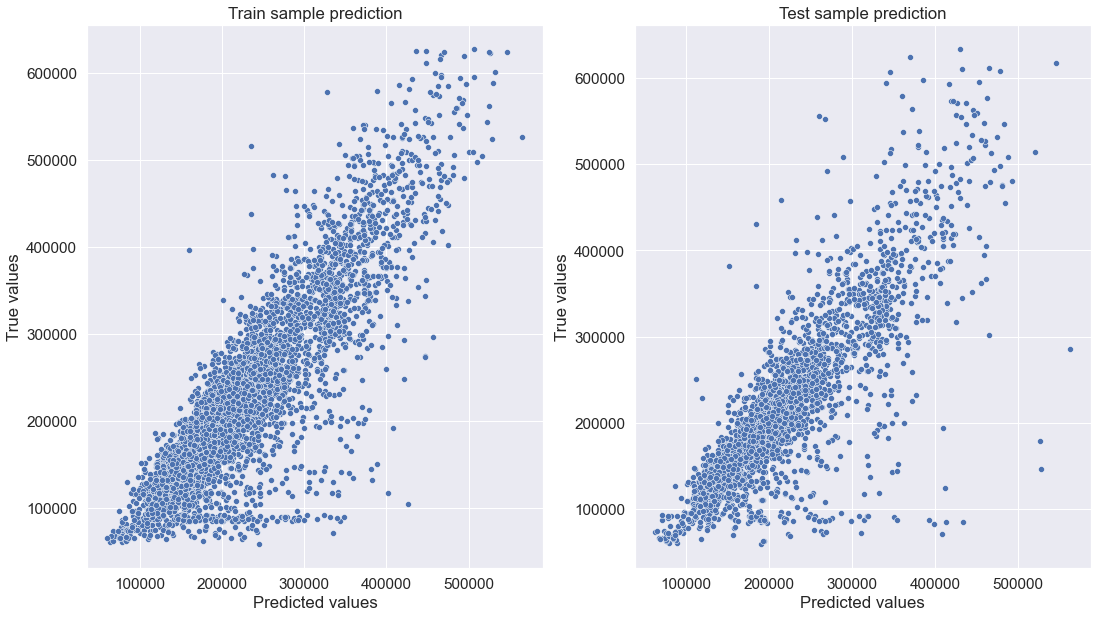

In [382]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

# Подбор гиперпараметров

In [383]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model

GradientBoostingRegressor(random_state=42)

In [384]:
params = {'n_estimators': [50, 100, 200, 400],
         'max_depth': [3, 5 , 7 ,10]}

In [385]:
gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=42, shuffle=True), n_jobs=-1)

In [386]:
gs.fit(X,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [387]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [388]:
gs.best_score_

0.7420477687583005

# Итоговая модель

Применим оптимальные параметры, которые мы получили выше

In [389]:
final_model = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=5)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [390]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

Train R2:	0.901
Test R2:	0.742


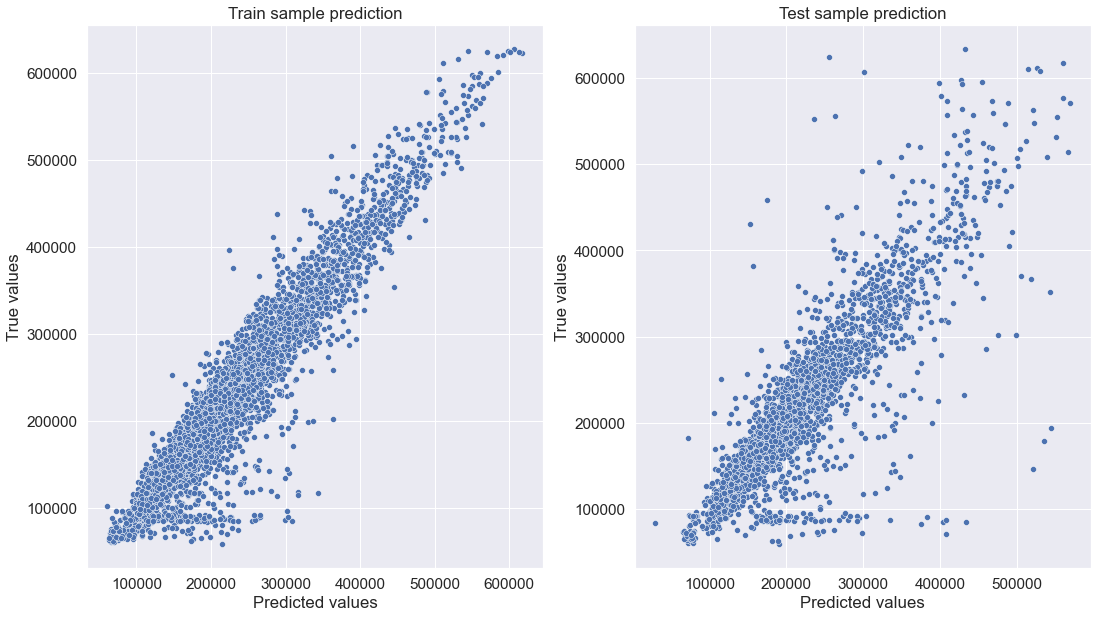

In [391]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

# Важность признаков

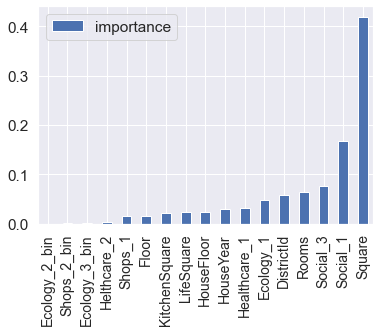

In [392]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': final_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)
feature_importances.reset_index(drop=True).plot(kind='bar')
plt.xticks(ticks=range(feature_importances.shape[0]), labels=feature_importances.feature,size=14)
plt.show()

Удалим очевидно малозначимые признаки "Ecology_3_bin, Shops_2_bin, Ecology_2_bin" и др.

In [393]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1']

In [394]:
X = train_df[feature_names]
y = train_df[target_name]

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [396]:
final_model = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=5)

In [397]:
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [398]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

Train R2:	0.896
Test R2:	0.736


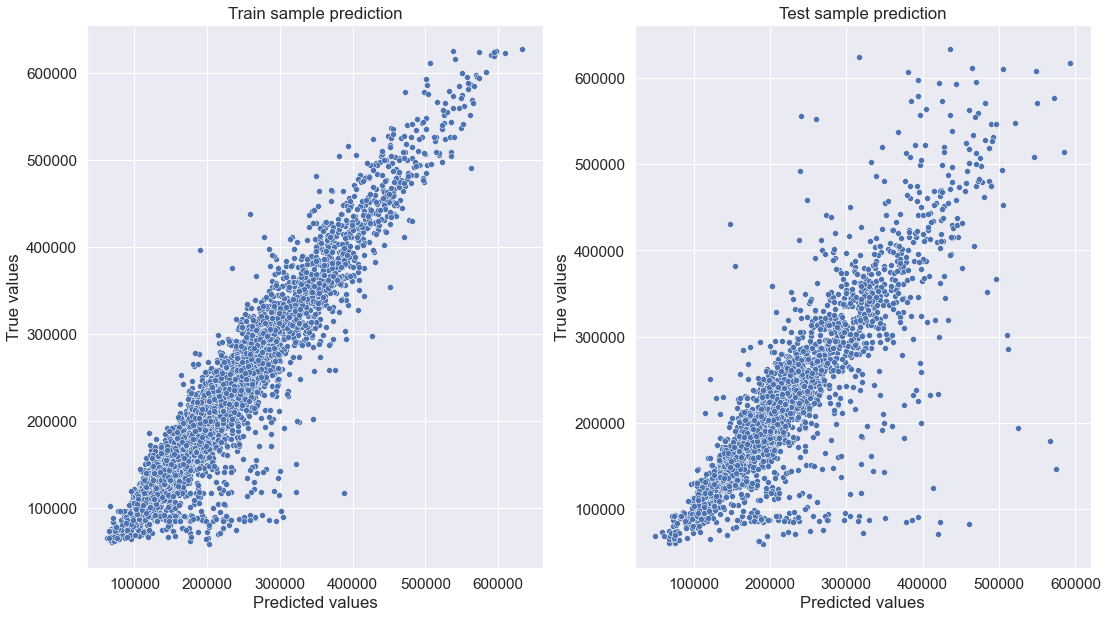

In [399]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

# Применение модели на тестовом датасете

In [400]:
y_test_preds = final_model.predict(test_df[feature_names])

In [401]:
test_df = pd.read_csv('Desktop/GeekBrains/test.csv')

In [402]:
result = pd.DataFrame()

In [403]:
result['Id'] = test_df['Id'].copy()

In [404]:
result['Price'] = pd.Series(y_test_preds)

In [405]:
result.to_csv('VladVologodskiy_predictions_GU_BigData.csv', index=False)

In [406]:
result.values

array([[   725.        , 155089.11229611],
       [ 15856.        , 213401.64489734],
       [  5480.        ,  32253.08774387],
       ...,
       [  5783.        , 309246.03350125],
       [  4780.        , 199477.96026106],
       [ 12504.        , 182333.37418351]])

In [407]:
result.shape

(5000, 2)

In [408]:

result['Price'].describe()


count      5000.000000
mean     215045.434892
std       80865.966294
min       32253.087744
25%      163247.752109
50%      194761.589002
75%      248348.715038
max      619473.901108
Name: Price, dtype: float64

In [409]:
result.tail(10)

,Id,Price
4990,15706,189802.758706
4991,2105,211559.860295
4992,7220,323040.001871
4993,14562,181548.755859
4994,6836,175523.051742
4995,8180,237992.569984
4996,4695,141192.444153
4997,5783,309246.033501
4998,4780,199477.960261
4999,12504,182333.374184
